# 넷플릭스 데이터 시각화
- 참조 사이트 : https://www.kaggle.com/code/joshuaswords/netflix-data-visualization

In [1]:
# Importing libs
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans, AffinityPropagation
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
import warnings
warnings.filterwarnings("ignore")
import plotly as py
import plotly.graph_objs as go
import os
py.offline.init_notebook_mode(connected = True)
import datetime as dt
import missingno as msno
plt.rcParams['figure.dpi'] = 140

In [2]:
df = pd.read_csv('Data/netflix_titles.csv')
df.head(3)

,show_id,type,title,director,cast,country,date_added,release_year,rating,duration,listed_in,description
0,s1,Movie,Dick Johnson Is Dead,Kirsten Johnson,NaN,United States,"September 25, 2021",2020,PG-13,90 min,Documentaries,"As her father nears the end of his life, filmm..."
1,s2,TV Show,Blood & Water,NaN,"Ama Qamata, Khosi Ngema, Gail Mabalane, Thaban...",South Africa,"September 24, 2021",2021,TV-MA,2 Seasons,"International TV Shows, TV Dramas, TV Mysteries","After crossing paths at a party, a Cape Town t..."
2,s3,TV Show,Ganglands,Julien Leclercq,"Sami Bouajila, Tracy Gotoas, Samuel Jouy, Nabi...",NaN,"September 24, 2021",2021,TV-MA,1 Season,"Crime TV Shows, International TV Shows, TV Act...",To protect his family from a powerful drug lor...


In [3]:
# null값 비중 파악하기
for i in df.columns:
    null_rate = df[i].isna().sum() / len(df) * 100
    if null_rate > 0:
        print("{} null rate : {}%".format(i, round(null_rate, 2)))

director null rate : 29.91%
cast null rate : 9.37%
country null rate : 9.44%
date_added null rate : 0.11%
rating null rate : 0.05%
duration null rate : 0.03%


## 누락된 데이터 처리
- 시나리오에 따라 다르게 수행하지만, 일반적으로 수행하는 방식:
    - 빈 나라를 최빈값(가장 일반적인) 국가로 대체하다
    - 특정 감독의 영화를 보는 것이 흥미로울 수 있기 때문에 나는 감독직을 유지하고 싶다
    - 특정 출연자의 영화를 보는 것이 흥미로울 수 있기 때문에 캐스팅을 유지하고 싶다

In [4]:
# 대체
df['country'] = df['country'].fillna(df['country'].mode()[0])

df['cast'].replace(np.nan, 'No Data', inplace=True)
df['director'].replace(np.nan, 'No Data',inplace  = True)

# 누락된 값 제거
df.dropna(inplace=True)

# 중복 값 제거
df.drop_duplicates(inplace=True)

In [5]:
df.isnull().sum()

show_id         0
type            0
title           0
director        0
cast            0
country         0
date_added      0
release_year    0
rating          0
duration        0
listed_in       0
description     0
dtype: int64

In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 8790 entries, 0 to 8806
Data columns (total 12 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   show_id       8790 non-null   object
 1   type          8790 non-null   object
 2   title         8790 non-null   object
 3   director      8790 non-null   object
 4   cast          8790 non-null   object
 5   country       8790 non-null   object
 6   date_added    8790 non-null   object
 7   release_year  8790 non-null   int64 
 8   rating        8790 non-null   object
 9   duration      8790 non-null   object
 10  listed_in     8790 non-null   object
 11  description   8790 non-null   object
dtypes: int64(1), object(11)
memory usage: 892.7+ KB


## 누락된 값을  처리했지만, 날짜가 object 형식이므로 datetime 형태로 바꿔줘야 함

In [7]:
# datetime형태로 변환
df['date_added'] = pd.to_datetime(df['date_added'])

df['month_added'] = df['date_added'].dt.month
df['month_name_added'] = df['date_added'].dt.month_name()
df['year_added'] = df['date_added'].dt.year

df.head(3)

,show_id,type,title,director,cast,country,date_added,release_year,rating,duration,listed_in,description,month_added,month_name_added,year_added
0,s1,Movie,Dick Johnson Is Dead,Kirsten Johnson,No Data,United States,2021-09-25,2020,PG-13,90 min,Documentaries,"As her father nears the end of his life, filmm...",9,September,2021
1,s2,TV Show,Blood & Water,No Data,"Ama Qamata, Khosi Ngema, Gail Mabalane, Thaban...",South Africa,2021-09-24,2021,TV-MA,2 Seasons,"International TV Shows, TV Dramas, TV Mysteries","After crossing paths at a party, a Cape Town t...",9,September,2021
2,s3,TV Show,Ganglands,Julien Leclercq,"Sami Bouajila, Tracy Gotoas, Samuel Jouy, Nabi...",United States,2021-09-24,2021,TV-MA,1 Season,"Crime TV Shows, International TV Shows, TV Act...",To protect his family from a powerful drug lor...,9,September,2021


## 시각화
### 사용할수 있다면, 넷플릭스 브랜드 색깔을 사용할 것임

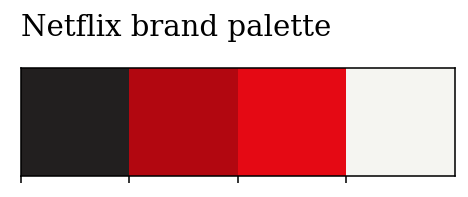

In [8]:
# palette
sns.palplot(['#221f1f', '#b20710', '#e50914','#f5f5f1'])

plt.title("Netflix brand palette ", loc='left', fontfamily='serif',fontsize=15, y=1.2)
plt.show()

## 수 년간의 넷플릭스
- 넷플릭스는 DVD 대여로 시작했고, 지금은 1억 5천만 명 이상의 시청자를 보유하고 있다

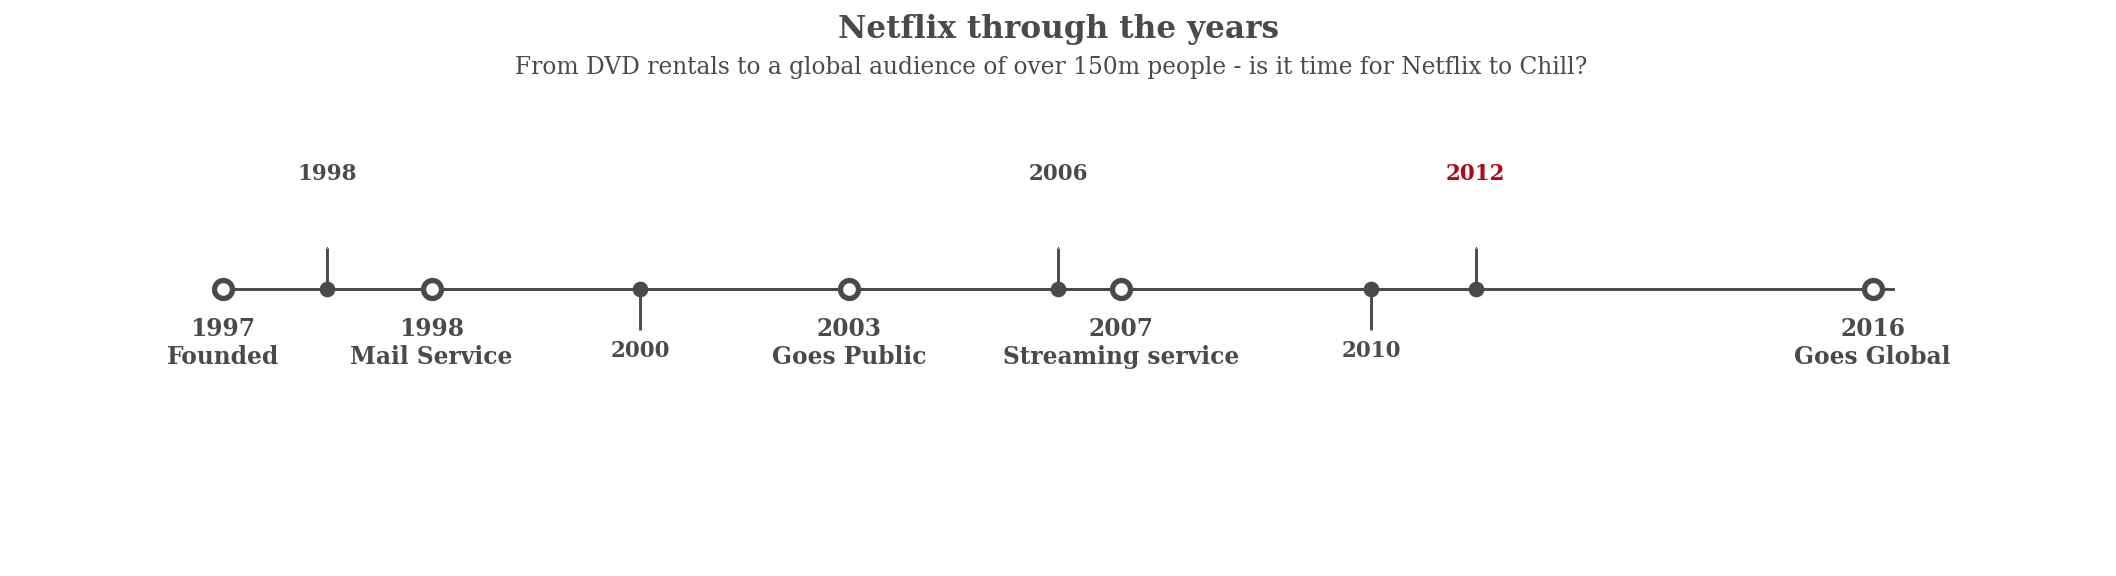

In [9]:
from datetime import datetime

tl_dates = [
    "1997\nFounded",
    "1998\nMail Service",
    "2003\nGoes Public",
    "2007\nStreaming service",
    "2016\nGoes Global",
    "2021\nNetflix & Chill"
]

tl_x = [1, 2, 4, 5.3, 8.9]
tl_sub_x = [1.5,3,5,6.5,7]
tl_sub_times = [
    "1998","2000","2006","2010","2012"
]
tl_text = [
    "Netflix.com launched",
    "Starts\nPersonal\nRecommendations","Billionth DVD Delivery","Canadian\nLaunch","UK Launch\n(my birthplace)"]

fig, ax = plt.subplots(figsize=(15,4), constrained_layout=True)
ax.set_ylim(-2, 1.75)
ax.set_xlim(0,10)

# 타임라인 : 선 -> 양 옆의 일부를 비워냄
ax.axhline(0, xmin=0.1, xmax=0.9, c='#4a4a4a', zorder=1) 

# 타임라인 : 날짜 포인트
# 커다란 점 지정
ax.scatter(tl_x, np.zeros(len(tl_x)), s=120, c='#4a4a4a', zorder=2)
ax.scatter(tl_x, np.zeros(len(tl_x)), s=30, c='#fafafa', zorder=3)

# 타임라인 : 시간 포인트
ax.scatter(tl_sub_x, np.zeros(len(tl_sub_x)), s=50, c='#4a4a4a', zorder=4)

# 날짜 텍스트 : 지정 위치에 텍스트 삽입
for x, date in zip(tl_x, tl_dates):
    ax.text(x, -0.55, date, ha='center', fontfamily='serif', fontweight='bold',
           color='#4a4a4a', fontsize=12)
    
# Stemplot : 수직 선
levels = np.zeros(len(tl_sub_x))
levels[::2] = 0.3
levels[1::2] = -0.3
markerline, stemline, baseline = ax.stem(tl_sub_x, levels, use_line_collection=True)
plt.setp(baseline, zorder=0)
plt.setp(markerline, marker=',', color='#4a4a4a')
plt.setp(stemline, color='#4a4a4a')

# 텍스트
for idx, x, time, txt in zip(range(1, len(tl_sub_x)+1), tl_sub_x, tl_sub_times, tl_text):
    ax.text(x, 1.3*(idx%2)-0.5, time, ha='center', fontfamily='serif',
           fontweight='bold',color='#4a4a4a' if idx!=len(tl_sub_x) else '#b20710', fontsize=11)

# 4방향 축이 모두 안보이게끔 설정
for spine in ["left", "top", "right", "bottom"]:
    ax.spines[spine].set_visible(False)
    
# 축값
ax.set_xticks([])
ax.set_yticks([])

# 제목
ax.set_title("Netflix through the years", fontweight="bold", fontfamily='serif', fontsize=16, color='#4a4a4a')
ax.text(2.4,1.57,"From DVD rentals to a global audience of over 150m people - is it time for Netflix to Chill?", fontfamily='serif', fontsize=12, color='#4a4a4a')

plt.show()

- constrained_layout=True : 서브 플롯 간의 간격 조절 -> 최적의 수치로 자동 조정
- axhline : 수평선
- zorder : 값을 지정해주면, 레이어의 위치라고 보면 됨.
- ax.text : 
    - x : x좌표
    - y : y좌표
    - s : 텍스트로 쓰고자 하는 내용
    - ha : 데이터 수평 정렬
- spines : 축 커스터마이징

## EDA
- 넷플릭스 제공 컨텐츠 살펴보기

In [10]:
x = df.groupby(['type'])['type'].count()
y = len(df)
r = ((x/y)).round(2)

mf_ratio = pd.DataFrame(r).T

In [11]:
mf_ratio

type,Movie,TV Show
type,0.7,0.3


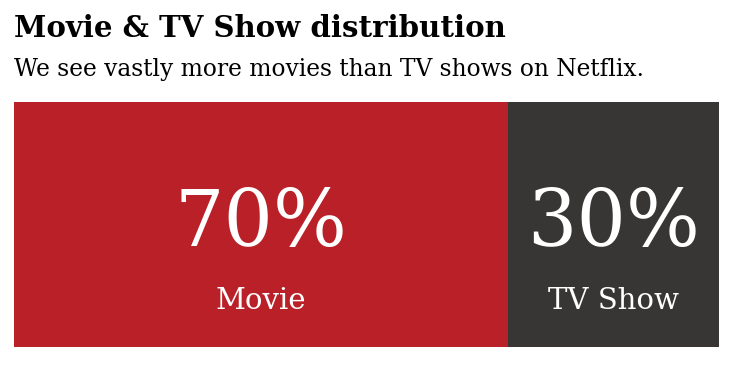

In [12]:
fig, ax = plt.subplots(1, 1, figsize=(6.5, 2.5))
ax.barh(mf_ratio.index, mf_ratio['Movie'], color='#b20710', alpha=0.9, label='Male')
ax.barh(mf_ratio.index, mf_ratio['TV Show'], left=mf_ratio['Movie'], color='#221f1f', alpha=0.9, label='Female')

ax.set_xlim(0, 1)
ax.set_xticks([])
ax.set_yticks([])

# 영화 비율
for i in mf_ratio.index:
    ax.annotate(f"{int(mf_ratio['Movie'][i]*100)}%", 
                   xy=(mf_ratio['Movie'][i]/2, i),
                   va = 'center', ha='center',fontsize=40, fontweight='light', fontfamily='serif',
                   color='white')

    ax.annotate("Movie", 
                   xy=(mf_ratio['Movie'][i]/2, -0.25),
                   va = 'center', ha='center',fontsize=15, fontweight='light', fontfamily='serif',
                   color='white')
    
# TV Show 비율    
for i in mf_ratio.index:
    ax.annotate(f"{int(mf_ratio['TV Show'][i]*100)}%", 
                   xy=(mf_ratio['Movie'][i]+mf_ratio['TV Show'][i]/2, i),
                   va = 'center', ha='center',fontsize=40, fontweight='light', fontfamily='serif',
                   color='white')
    ax.annotate("TV Show", 
                   xy=(mf_ratio['Movie'][i]+mf_ratio['TV Show'][i]/2, -0.25),
                   va = 'center', ha='center',fontsize=15, fontweight='light', fontfamily='serif',
                   color='white')






# 제목
fig.text(0.125,1.03,'Movie & TV Show distribution', fontfamily='serif',fontsize=15, fontweight='bold')
fig.text(0.125,0.92,'We see vastly more movies than TV shows on Netflix.',fontfamily='serif',fontsize=12)  

for s in ['top', 'left', 'right', 'bottom']:
    ax.spines[s].set_visible(False)
    

# legend 안보이게 하기
ax.legend().set_visible(False)
plt.show()

- annotate : 주석 달기
    - s : 내용
    - xy : 좌표

## 도시별 분류
- 그래서 우리는 이제 넷플릭스의 TV 쇼보다 훨씬 더 많은 영화가 있다는 것을 알고 있다.

- 나라별로 내용을 살펴보면 어떨까?

- 나는 미국이 가장 많은 콘텐츠를 가질 것이라고 상상할 것이다.

In [13]:
df['count'] = 1

df['first_country'] = df['country'].apply(lambda x:x.split(",")[0])
df['first_country'].head()

ratings_ages = {
    'TV-PG': 'Older Kids',
    'TV-MA': 'Adults',
    'TV-Y7-FV': 'Older Kids',
    'TV-Y7': 'Older Kids',
    'TV-14': 'Teens',
    'R': 'Adults',
    'TV-Y': 'Kids',
    'NR': 'Adults',
    'PG-13': 'Teens',
    'TV-G': 'Kids',
    'PG': 'Older Kids',
    'G': 'Kids',
    'UR': 'Adults',
    'NC-17': 'Adults'
}

df['target_ages'] = df['rating'].replace(ratings_ages)
df['target_ages'].unique()

# 장르
df['genre'] = df['listed_in'].apply(lambda x : x.replace(' ,',',').replace(', ',',').split(','))

# 국가명 길이 줄이기
df['first_country'].replace('United Status', 'US', inplace=True)
df['first_country'].replace('United Kingdom', 'UK',inplace=True)
df['first_country'].replace('South Korea', 'S. Korea',inplace=True)

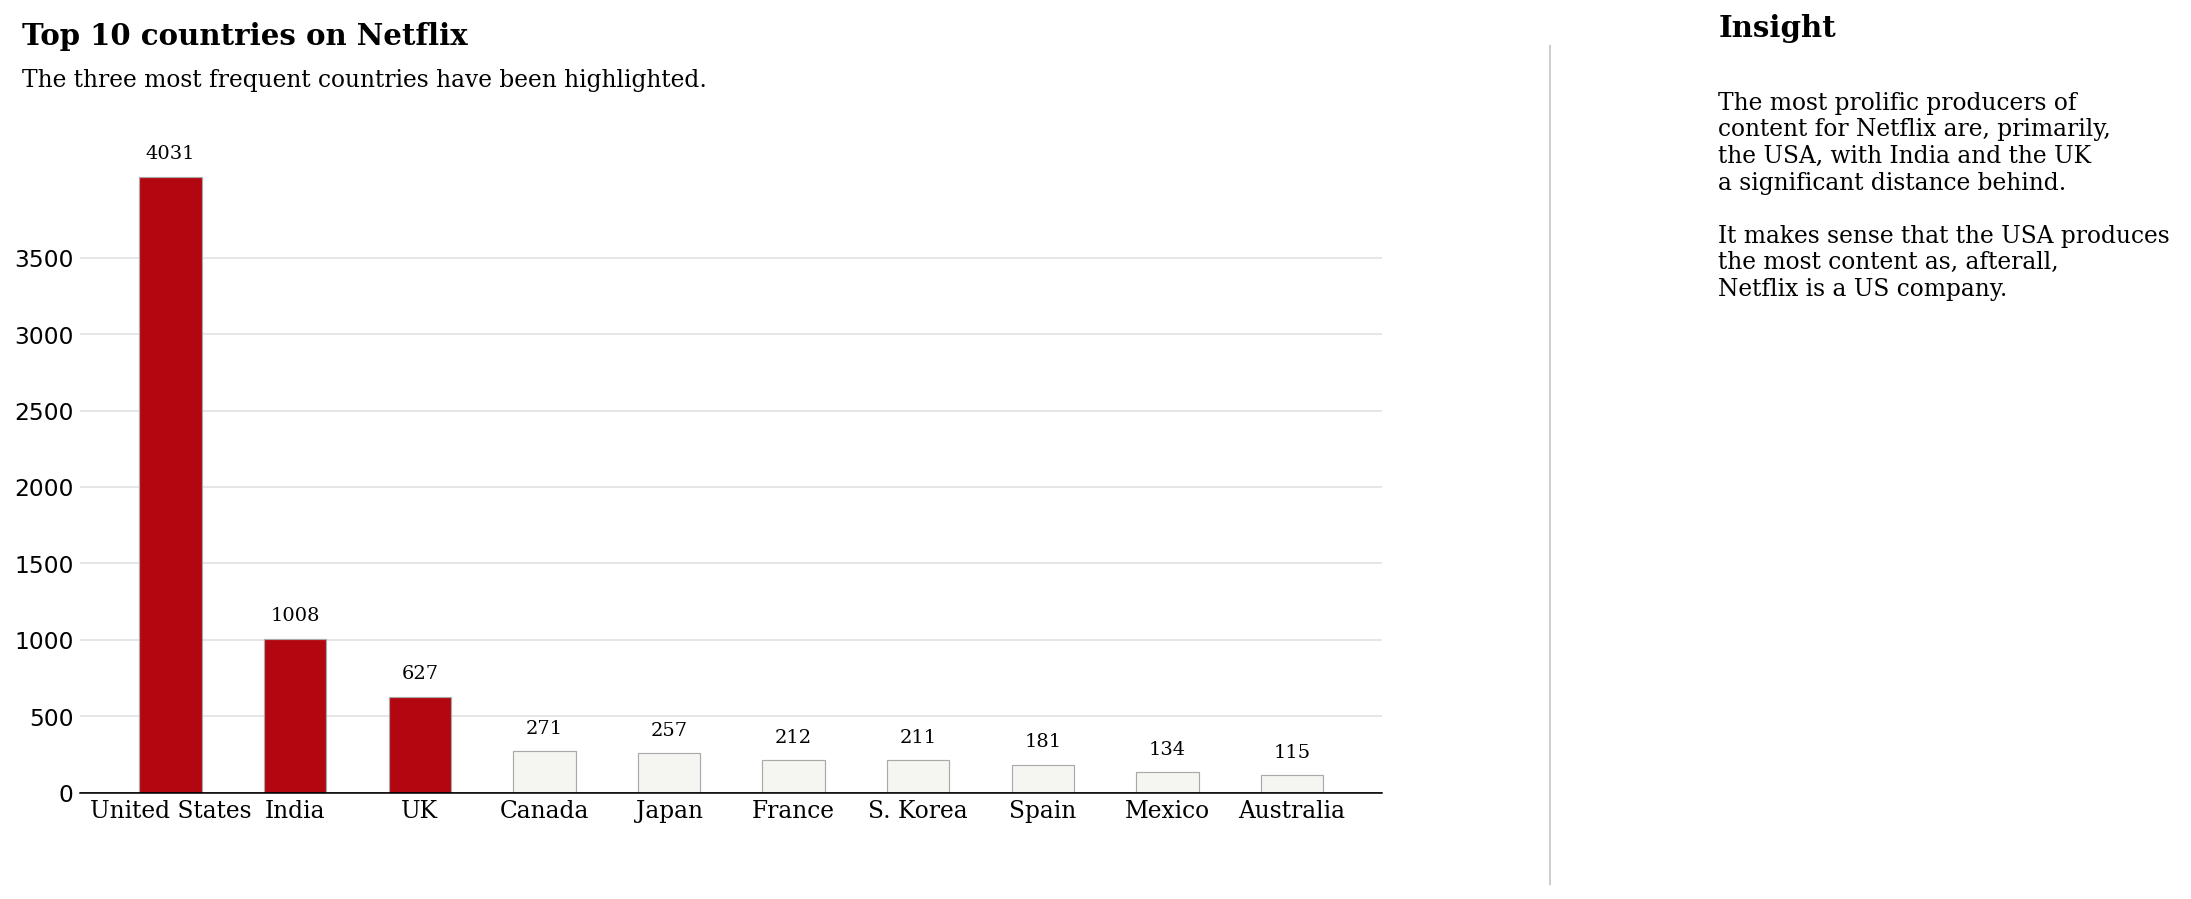

In [14]:
data = df.groupby('first_country')['count'].sum().sort_values(ascending=False)[:10]

# 시각화
color_map = ['#f5f5f1' for _ in range(10)]
color_map[0] = color_map[1] = color_map[2] = '#b20710' # 색 강조(상위 3개만 색 변환)

fig, ax = plt.subplots(1,1, figsize=(12,6))
ax.bar(data.index, data, width=0.5, edgecolor='darkgray',
      linewidth=0.6, color=color_map)

# 주석 추가
for i in data.index:
    ax.annotate(f"{data[i]}", xy=(i, data[i]+150),va='center', ha='center',
               fontweight='light', fontfamily='serif')
    
# 그래프에서 테두리 제거
for s in ['top','left','right']:
    ax.spines[s].set_visible(False)
    
# 축    
ax.set_xticklabels(data.index, fontfamily='serif', rotation=0)

fig.text(0.09, 1, 'Top 10 countries on Netflix', fontsize=15, fontweight='bold', fontfamily='serif')
fig.text(0.09, 0.95, 'The three most frequent countries have been highlighted.', fontsize=12, fontweight='light', fontfamily='serif')

fig.text(1.1, 1.01, 'Insight', fontsize=15, fontweight='bold', fontfamily='serif')
fig.text(1.1, 0.67, '''
The most prolific producers of
content for Netflix are, primarily,
the USA, with India and the UK
a significant distance behind.

It makes sense that the USA produces 
the most content as, afterall, 
Netflix is a US company.
'''
         , fontsize=12, fontweight='light', fontfamily='serif')

# 그리드 지정
ax.grid(axis='y', linestyle='-', alpha=0.4) # 

grid_y_ticks = np.arange(0, 4000, 500)
ax.set_yticks(grid_y_ticks)
ax.set_axisbelow(True)

plt.axhline(y = 0, color = 'black', linewidth = 1.3, alpha = .7)

# 눈금 커스터마이징
ax.tick_params(axis='both', which='major', labelsize=12)

import matplotlib.lines as lines
# 구분선 추가
l1 = lines.Line2D([1, 1], [0, 1], transform=fig.transFigure, figure=fig, color='black', lw=0.2)
fig.lines.extend([l1])

ax.tick_params(axis=u'both', which=u'both',length=0)

plt.show()

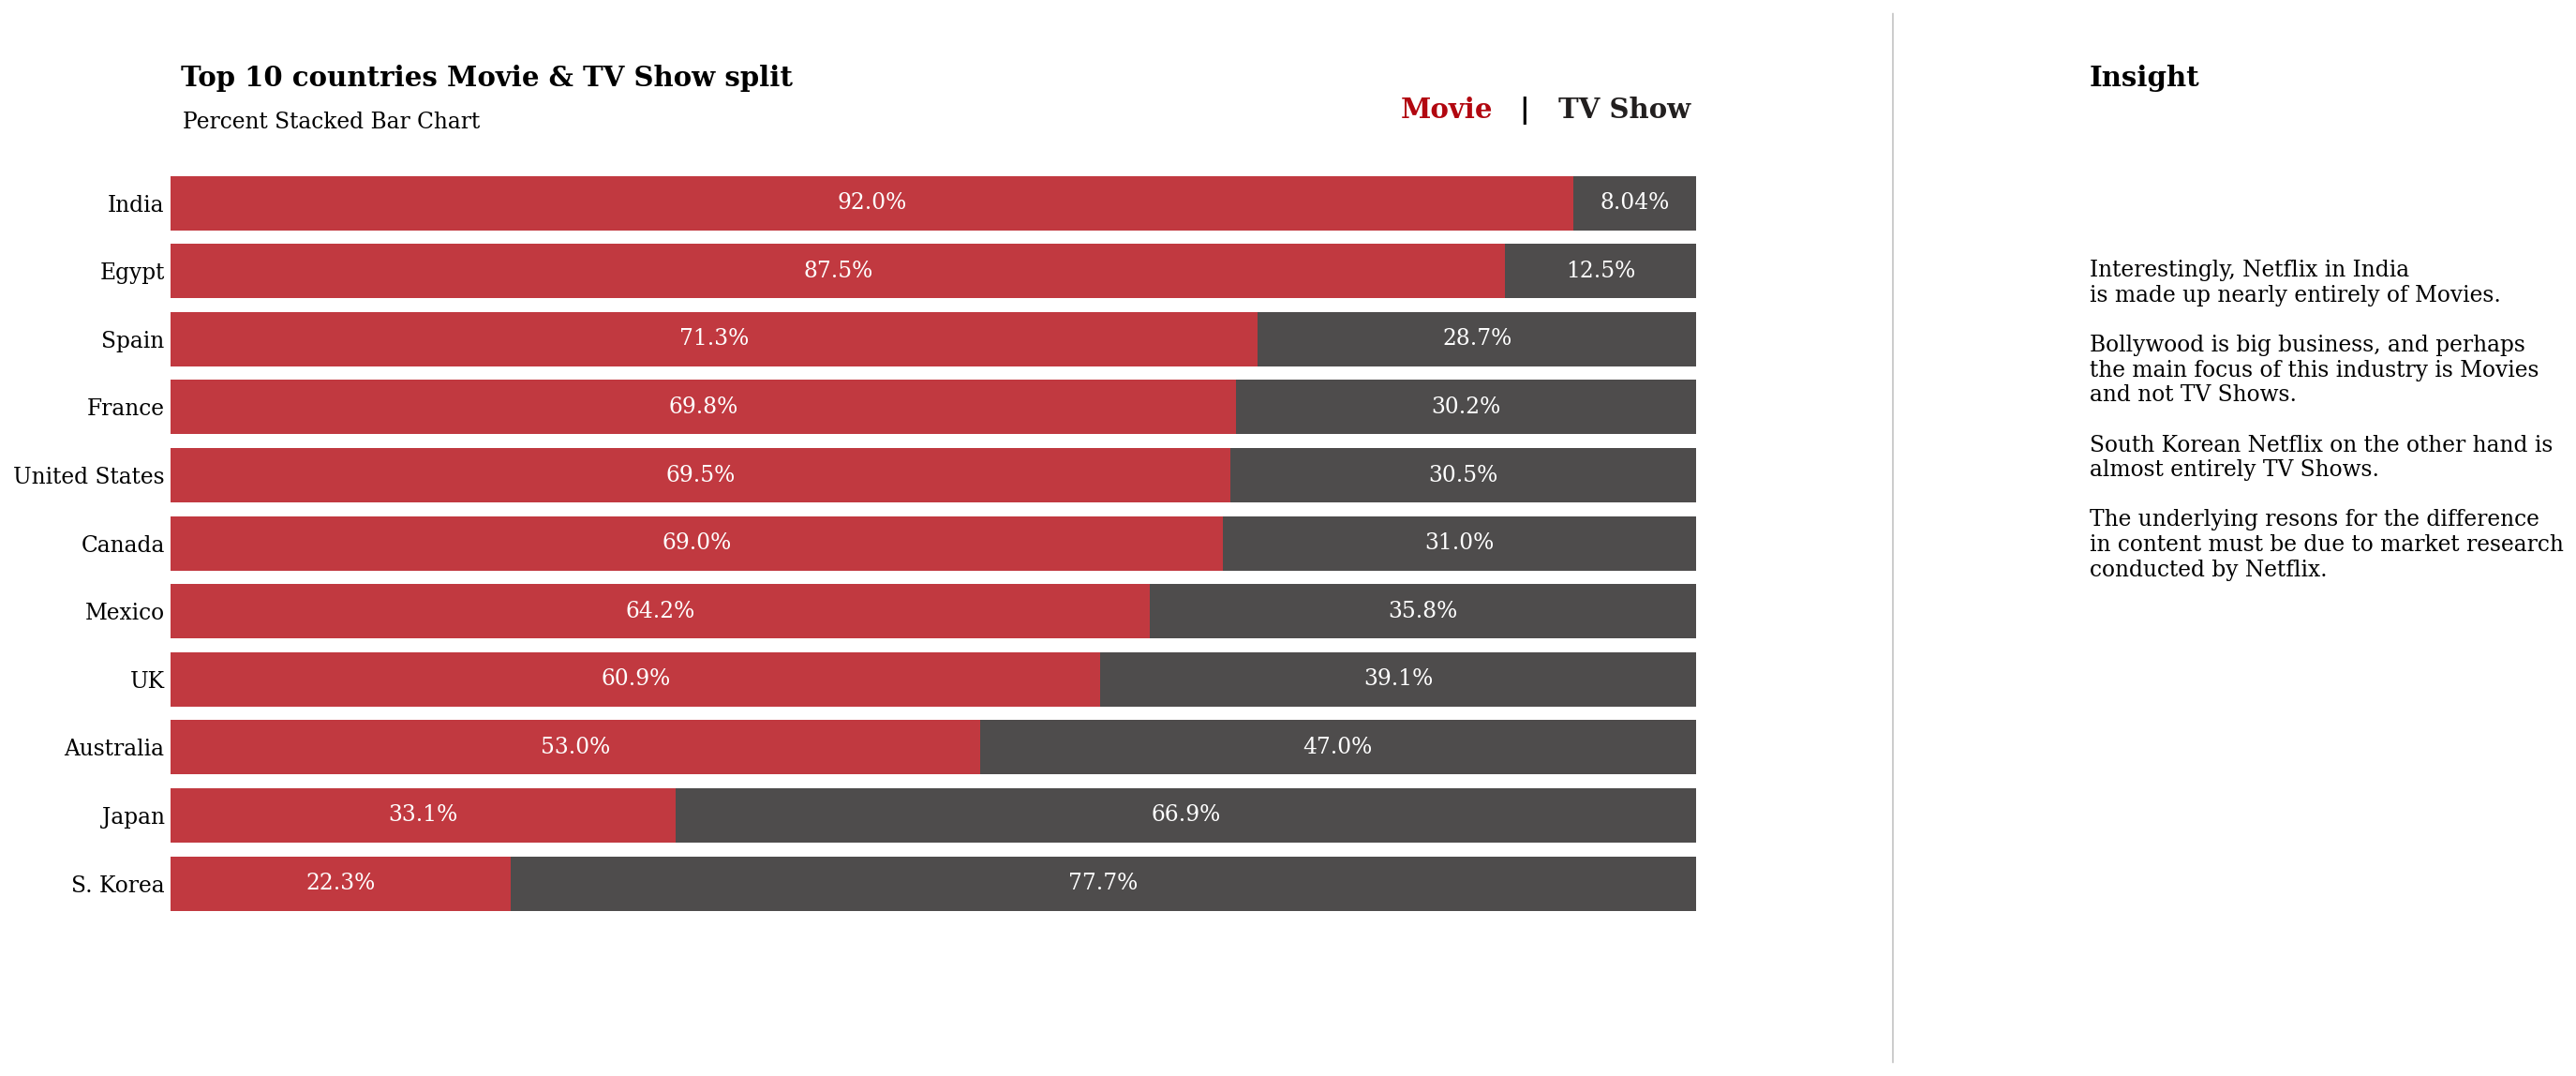

In [15]:
country_order = df['first_country'].value_counts()[:11].index
data_q2q3 = df[['type','first_country']].groupby('first_country')['type'].value_counts().unstack().loc[country_order]
data_q2q3['sum'] = data_q2q3.sum(axis=1)
data_q2q3_ratio = (data_q2q3.T / data_q2q3['sum']).T[['Movie', 'TV Show']].sort_values(by='Movie',ascending=False)[::-1]

fig, ax = plt.subplots(1,1,figsize=(15, 8))

ax.barh(data_q2q3_ratio.index, data_q2q3_ratio['Movie'], 
        color='#b20710', alpha=0.8, label='Movie')
ax.barh(data_q2q3_ratio.index, data_q2q3_ratio['TV Show'], left=data_q2q3_ratio['Movie'], 
        color='#221f1f', alpha=0.8, label='TV Show')

ax.set_xlim(0,1)
ax.set_xticks([])
ax.set_yticklabels(data_q2q3_ratio.index, fontfamily='serif', fontsize=11)

# 비율을 주석으로 출력
for i in data_q2q3_ratio.index:
    ax.annotate(f"{data_q2q3_ratio['Movie'][i]*100:.3}%", 
                   xy=(data_q2q3_ratio['Movie'][i]/2, i),
                   va = 'center', ha='center',fontsize=12, fontweight='light', fontfamily='serif',
                   color='white')

for i in data_q2q3_ratio.index:
    ax.annotate(f"{data_q2q3_ratio['TV Show'][i]*100:.3}%", 
                   xy=(data_q2q3_ratio['Movie'][i]+data_q2q3_ratio['TV Show'][i]/2, i),
                   va = 'center', ha='center',fontsize=12, fontweight='light', fontfamily='serif',
                   color='white')
    
fig.text(0.13, 0.93, 'Top 10 countries Movie & TV Show split', fontsize=15, fontweight='bold', fontfamily='serif')   
fig.text(0.131, 0.89, 'Percent Stacked Bar Chart', fontsize=12,fontfamily='serif')   

for s in ['top', 'left', 'right', 'bottom']:
    ax.spines[s].set_visible(False)

# 기타 텍스트 삽입 (subplot 바깥의 텍스트)
fig.text(0.75,0.9,"Movie", fontweight="bold", fontfamily='serif', fontsize=15, color='#b20710')
fig.text(0.81,0.9,"|", fontweight="bold", fontfamily='serif', fontsize=15, color='black')
fig.text(0.83,0.9,"TV Show", fontweight="bold", fontfamily='serif', fontsize=15, color='#221f1f')

fig.text(1.1, 0.93, 'Insight', fontsize=15, fontweight='bold', fontfamily='serif')
fig.text(1.1, 0.44, '''
Interestingly, Netflix in India
is made up nearly entirely of Movies. 

Bollywood is big business, and perhaps
the main focus of this industry is Movies
and not TV Shows.

South Korean Netflix on the other hand is 
almost entirely TV Shows.

The underlying resons for the difference 
in content must be due to market research
conducted by Netflix.
'''
         , fontsize=12, fontweight='light', fontfamily='serif')

import matplotlib.lines as lines
l1 = lines.Line2D([1, 1], [0, 1], transform=fig.transFigure, figure=fig,color='black',lw=0.2)
fig.lines.extend([l1])




ax.tick_params(axis='both', which='major', labelsize=12)
ax.tick_params(axis=u'both', which=u'both',length=0)

plt.show()

- unstack : 인덱스 값을 칼럼으로 옮겨줌
    - 아무 언급이 없다면 제일 level이 높은 인덱스부터 하나씩 올려줌

## Ratings (평점)

In [16]:
order = pd.DataFrame(df.groupby('rating')['count'].sum().sort_values(ascending=False).reset_index())
rating_order = list(order['rating'])

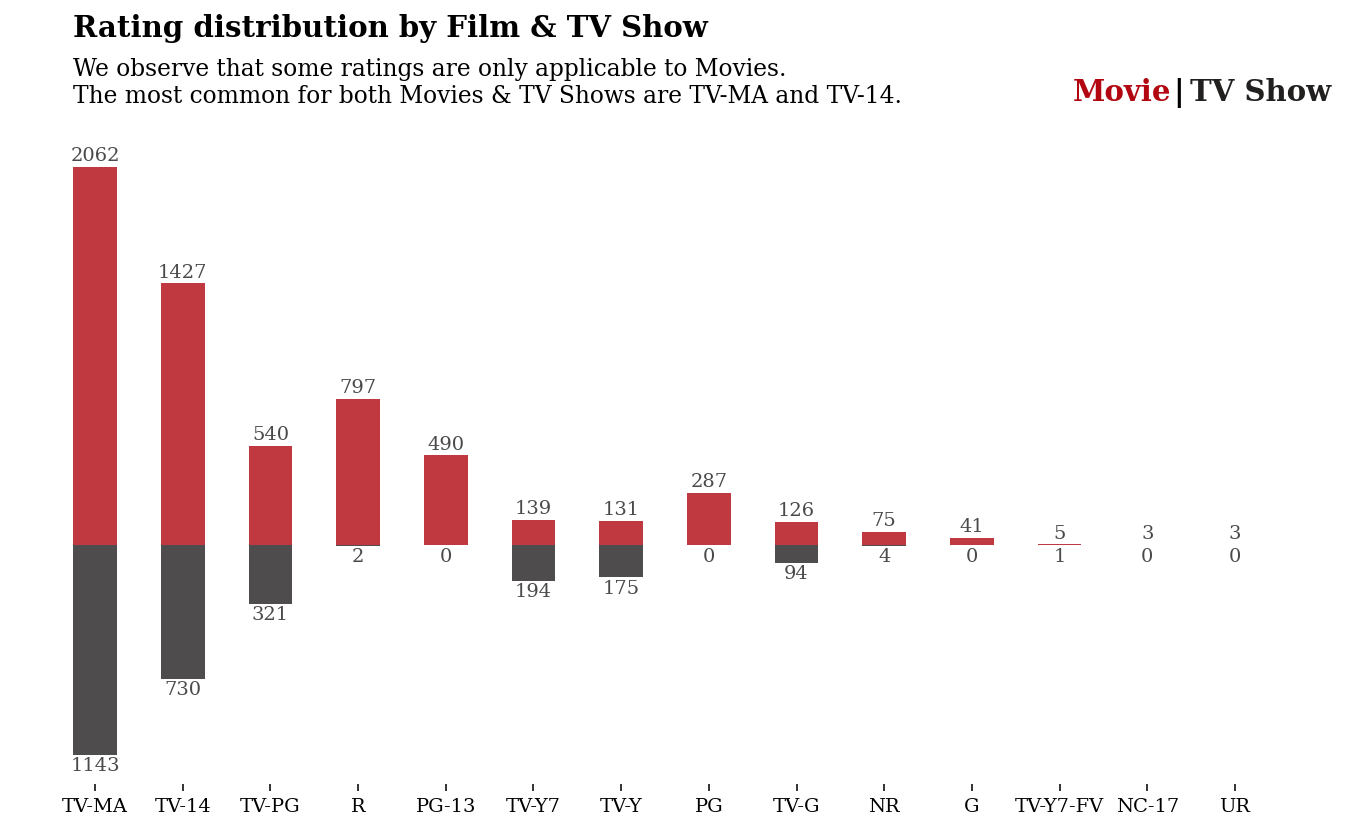

In [17]:
mf = df.groupby('type')['rating'].value_counts().unstack().sort_index().fillna(0).astype(int)[rating_order]
# 그래프를 위아래 형식으로 지정하기 위해 tv에 -를 붙임
movie = mf.loc['Movie']
tv = - mf.loc['TV Show'] 
fig, ax = plt.subplots(1,1, figsize=(12, 6))
ax.bar(movie.index, movie, width=0.5, color='#b20710', alpha=0.8, label='Movie')
ax.bar(tv.index, tv, width=0.5, color='#221f1f', alpha=0.8, label='TV Show')

# 주석 달기
for i in tv.index:
    ax.annotate(f"{-tv[i]}", xy=(i, tv[i]-60), va='center',ha='center',
               fontweight='light', fontfamily='serif', color='#4a4a4a')
for i in movie.index:
    ax.annotate(f"{movie[i]}", 
                   xy=(i, movie[i] + 60),
                   va = 'center', ha='center',fontweight='light', fontfamily='serif',
                   color='#4a4a4a')
    
for s in ['top', 'left', 'right', 'bottom']:
    ax.spines[s].set_visible(False)

ax.set_xticklabels(mf.columns, fontfamily='serif')
ax.set_yticks([])    

ax.legend().set_visible(False)
fig.text(0.16, 1, 'Rating distribution by Film & TV Show', fontsize=15, fontweight='bold', fontfamily='serif')
fig.text(0.16, 0.89, 
'''We observe that some ratings are only applicable to Movies. 
The most common for both Movies & TV Shows are TV-MA and TV-14.
'''

, fontsize=12, fontweight='light', fontfamily='serif')

fig.text(0.755,0.924,"Movie", fontweight="bold", fontfamily='serif', fontsize=15, color='#b20710')
fig.text(0.815,0.924,"|", fontweight="bold", fontfamily='serif', fontsize=15, color='black')
fig.text(0.825,0.924,"TV Show", fontweight="bold", fontfamily='serif', fontsize=15, color='#221f1f')

plt.show()

## 몇년간 컨텐츠가 어떻게 추가되었을까?

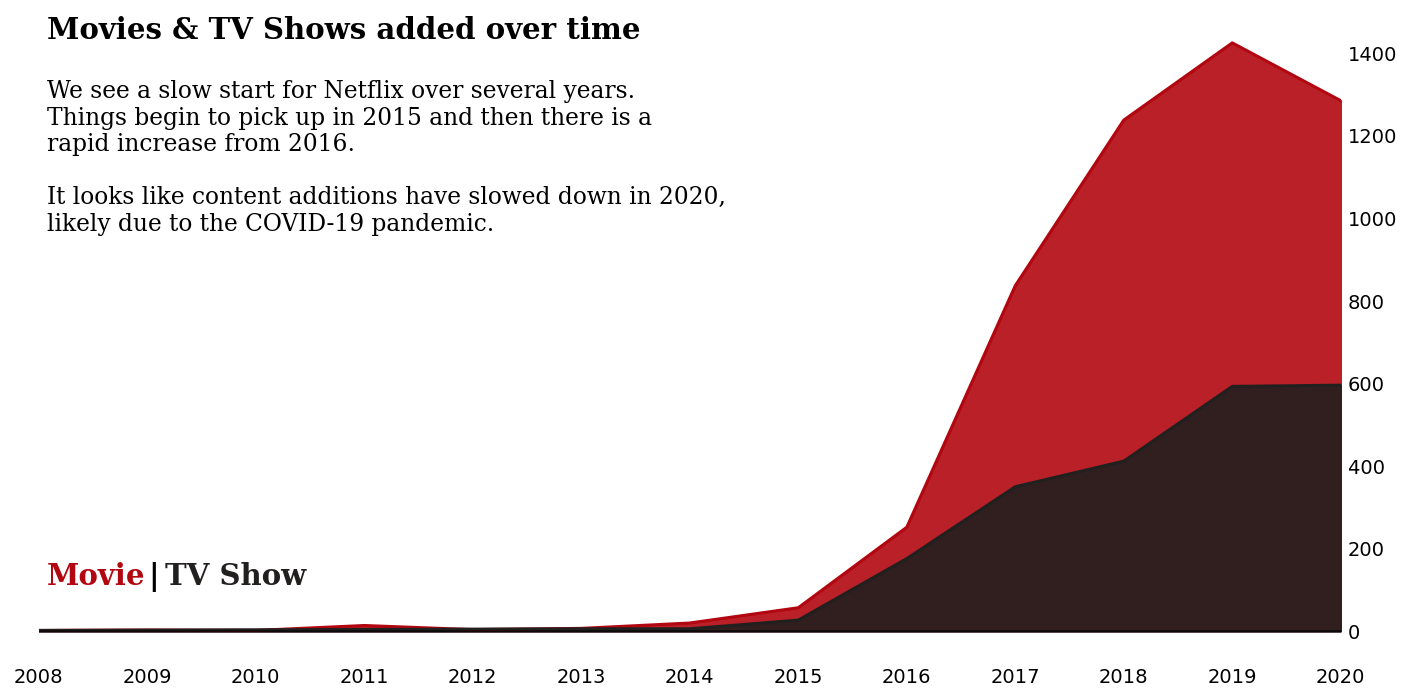

In [18]:
fig, ax = plt.subplots(1,1, figsize=(12,6))
color = ["#b20710", "#221f1f"]

for i, mtv in enumerate(df['type'].value_counts().index):
    mtv_rel = df[df['type']==mtv]['year_added'].value_counts().sort_index()
    ax.plot(mtv_rel.index, mtv_rel, color=color[i], label=mtv) # 선그래프 그리기
    ax.fill_between(mtv_rel.index, 0, mtv_rel, color=color[i], alpha=0.9) # 밑에 칠하면서 채우기
    # 축을 우측으로 이동
ax.yaxis.tick_right()
# 수평선 추가
ax.axhline(y = 0, color = 'black', linewidth = 1.3, alpha = .7)
    
for s in ['top', 'right','bottom','left']:
    ax.spines[s].set_visible(False)
# 그리드 (x선, y선 없애기)
ax.grid(False)

ax.set_xlim(2008,2020)
plt.xticks(np.arange(2008, 2021, 1))

fig.text(0.13, 0.85, 'Movies & TV Shows added over time', fontsize=15, fontweight='bold', fontfamily='serif')
fig.text(0.13, 0.59, 
'''We see a slow start for Netflix over several years. 
Things begin to pick up in 2015 and then there is a 
rapid increase from 2016.

It looks like content additions have slowed down in 2020, 
likely due to the COVID-19 pandemic.
'''

, fontsize=12, fontweight='light', fontfamily='serif')


fig.text(0.13,0.2,"Movie", fontweight="bold", fontfamily='serif', fontsize=15, color='#b20710')
fig.text(0.19,0.2,"|", fontweight="bold", fontfamily='serif', fontsize=15, color='black')
fig.text(0.2,0.2,"TV Show", fontweight="bold", fontfamily='serif', fontsize=15, color='#221f1f')

ax.tick_params(axis=u'both', which=u'both',length=0)

plt.show()


In [35]:
month_order = ['January',
 'February',
 'March',
 'April',
 'May',
 'June',
 'July',
 'August',
 'September',
 'October',
 'November',
 'December']

df['month_name_added'] = pd.Categorical(df['month_name_added'], categories=month_order, ordered=True)

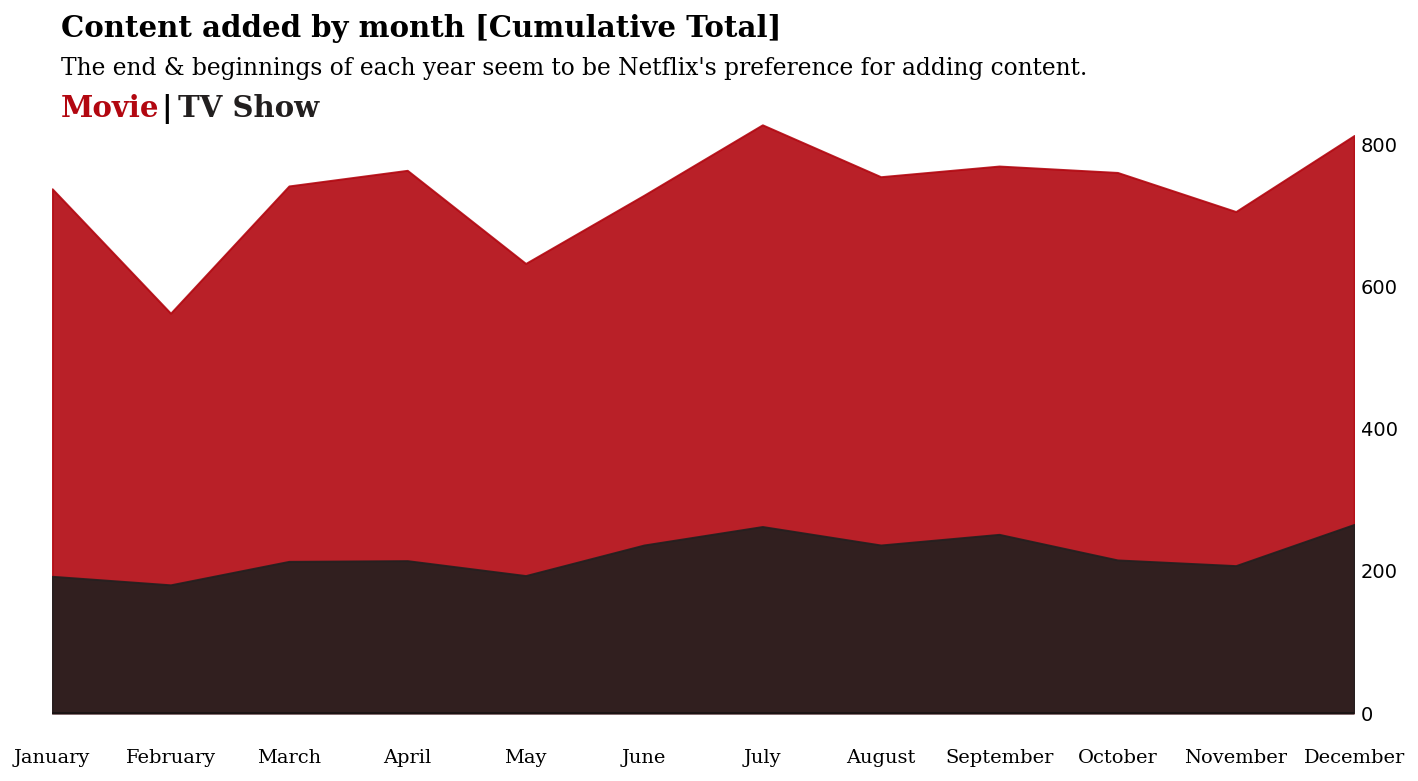

In [36]:
data_sub = df.groupby('type')['month_name_added'].value_counts().unstack().fillna(0).loc[['TV Show','Movie']].cumsum(axis=0).T

fig, ax = plt.subplots(1, 1, figsize=(12,6))
color = ["#b20710", "#221f1f"]

for i, mtv in enumerate(df['type'].value_counts().index): # 영화, tv쇼
    mtv_rel = data_sub[mtv]
    ax.fill_between(mtv_rel.index, 0, mtv_rel, color=color[i], label=mtv, alpha=0.9)
    
ax.yaxis.tick_right()

ax.axhline(y=0, color='black', linewidth=1.3, alpha=.4) 
    
for s in ['top','right','bottom','left']:
    ax.spines[s].set_visible(False)
    
ax.grid(False)
ax.set_xticklabels(data_sub.index, fontfamily='serif', rotation=0)
ax.margins(x=0) # 여백 제거

fig.text(0.13, 0.95, 'Content added by month [Cumulative Total]', fontsize=15, fontweight='bold', fontfamily='serif')
fig.text(0.13, 0.905, 
"The end & beginnings of each year seem to be Netflix's preference for adding content."

, fontsize=12, fontweight='light', fontfamily='serif')

fig.text(0.13,0.855,"Movie", fontweight="bold", fontfamily='serif', fontsize=15, color='#b20710')
fig.text(0.19,0.855,"|", fontweight="bold", fontfamily='serif', fontsize=15, color='black')
fig.text(0.2,0.855,"TV Show", fontweight="bold", fontfamily='serif', fontsize=15, color='#221f1f')

ax.tick_params(axis=u'both', which=u'both',length=0)

plt.show()

## 1년 동안 콘텐츠가 어떻게 추가되는지를 더 흥미롭게 볼 수 있는 방법?

- 특정 달을 강조 표시함으로써, 독자의 시선은 우리가 원하는 곳에 정확히 그려진다.

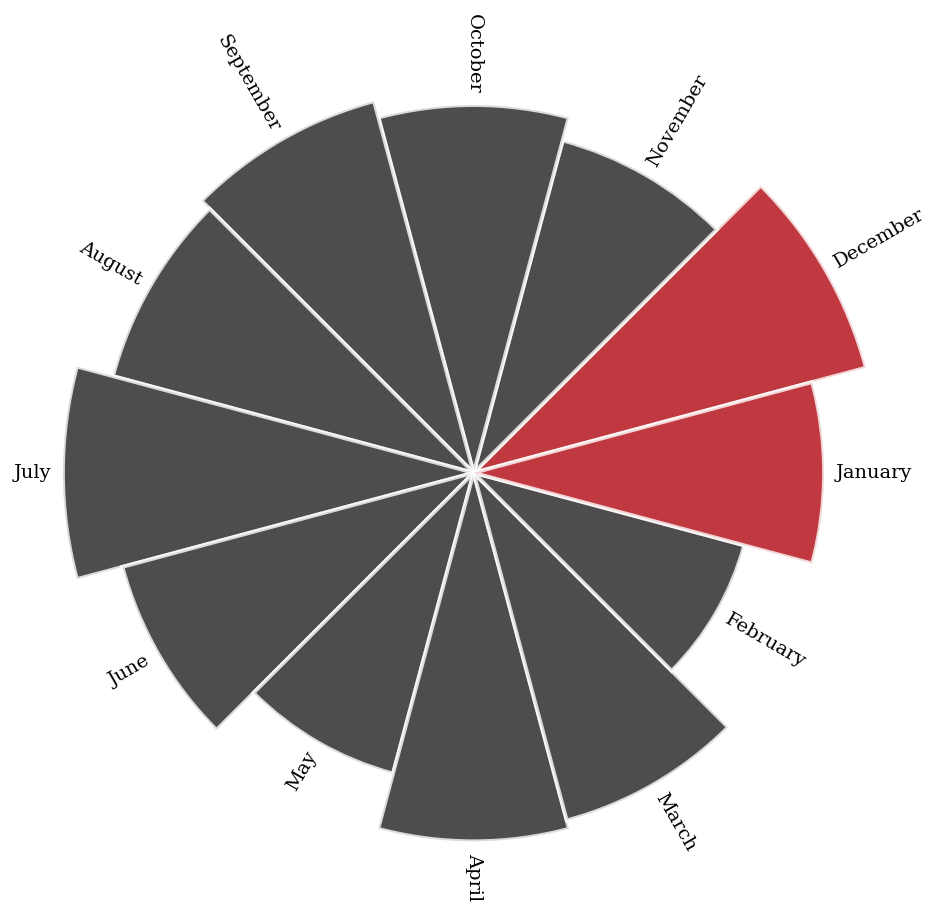

In [59]:
data_sub2 = data_sub

data_sub2['Value'] = data_sub2['Movie'] + data_sub2['TV Show']
data_sub2 = data_sub2.reset_index()

df_polar = data_sub2.sort_values(by='index',ascending=False)

color_map = ['#221f1f' for _ in range(12)]
color_map[0] = color_map[11] =  '#b20710' # color 하이라이트

plt.figure(figsize=(8,8))
ax = plt.subplot(111, polar=True) # 원형으로 그리기
plt.axis('off')

# 상수 = 그림 레이아웃을 제어하는 모수:
upperLimit = 30
lowerLimit=1
labelPadding=30

# 데이터 최대, 최소 계산
max = df_polar['Value'].max()

# 높이를 계산해 봅시다. 새 좌표의 각 항목 값을 변환한 것입니다
# 이 예에서는 데이터 집합의 0이 lowerLimit(10)로 변환됩니다
# 최대값은 상한(100)으로 변환됩니다
slope = (max-lowerLimit) / max
heights = slope * df_polar.Value + lowerLimit

# 각 막대의 너비를 계산합니다. 총 2*Pi = 360°
width = 2*np.pi / len(df_polar.index)

# 중심 각도 계산
indexes = list(range(1, len(df_polar.index)+1))
angles = [element * width for element in indexes]
angles

# 바그래프 그리기
bars = ax.bar(x=angles, height=heights, width=width, bottom=lowerLimit,
             linewidth=2, edgecolor='white', color=color_map, alpha=0.8)

# 라벨 추가
for bar, angle, height, label in zip(bars,angles, heights, df_polar["index"]):
    # 레이블이 회전, 회전은 도 단위로 지정해야 함.
    rotation = np.rad2deg(angle) # 각도를 라디안에서 각도로 변환
    
    # 일부 레이블 거꾸로 뒤집기
    alignment = ""
    if angle >= np.pi/2 and angle <3*np.pi/2:
        alignment='right'
        rotation = rotation + 180
    else:
        alignment='left'
        
    # 라벨 추가
    ax.text(
        x=angle, 
        y=lowerLimit + bar.get_height() + labelPadding, 
        s=label, 
        ha=alignment, fontsize=10,fontfamily='serif',
        va='center', 
        rotation=rotation, 
        rotation_mode="anchor") 

- 12월과 1월은 확실히 새로운 콘텐츠를 위한 최고의 달입니다. 아마도 넷플릭스는 사람들이 이 기간 동안 일을 쉬는 시간이 많고 사람들을 끌어들이기에 좋은 시간이라는 것을 알고 있을 것이다

## 영화 장르

In [65]:
from sklearn.preprocessing import MultiLabelBinarizer # 다중 라벨 이진화
import matplotlib.colors

cmap = matplotlib.colors.LinearSegmentedColormap.from_list("", ['#221f1f', '#b20710','#f5f5f1'])

def genre_heatmap(df, title):
    df['genre'] = df['listed_in'].apply(lambda x :  x.replace(' ,',',').replace(', ',',').split(',')) 
    Types = []
    for i in df['genre']: Types += i
    Types = set(Types)
    print("There are {} types in the Netflix {} Dataset".format(len(Types),title))    
    test = df['genre']
    mlb = MultiLabelBinarizer()
    res = pd.DataFrame(mlb.fit_transform(test), columns=mlb.classes_, index=test.index)
    corr = res.corr()
    mask = np.zeros_like(corr, dtype=np.bool)
    mask[np.triu_indices_from(mask)] = True
    fig, ax = plt.subplots(figsize=(10, 7))
    fig.text(.54,.88,'Genre correlation', fontfamily='serif',fontweight='bold',fontsize=15)
    fig.text(.75,.665,
            '''
             It is interesting that Independant Movies
             tend to be Dramas. 
             
             Another observation is that 
             Internatinal Movies are rarely
             in the Children's genre.
             ''', fontfamily='serif',fontsize=12,ha='right')
    pl = sns.heatmap(corr, mask=mask, cmap=cmap, vmax=.3, vmin=-.3, center=0, square=True, linewidths=2.5)
    
    plt.show()

- np.triu_indices_from() = True : 삼각형 마스크를 만든다(위 쪽 삼각형에 True, 아래 삼각형에 False) -> True 영역만 시각화

There are 20 types in the Netflix Movie Dataset


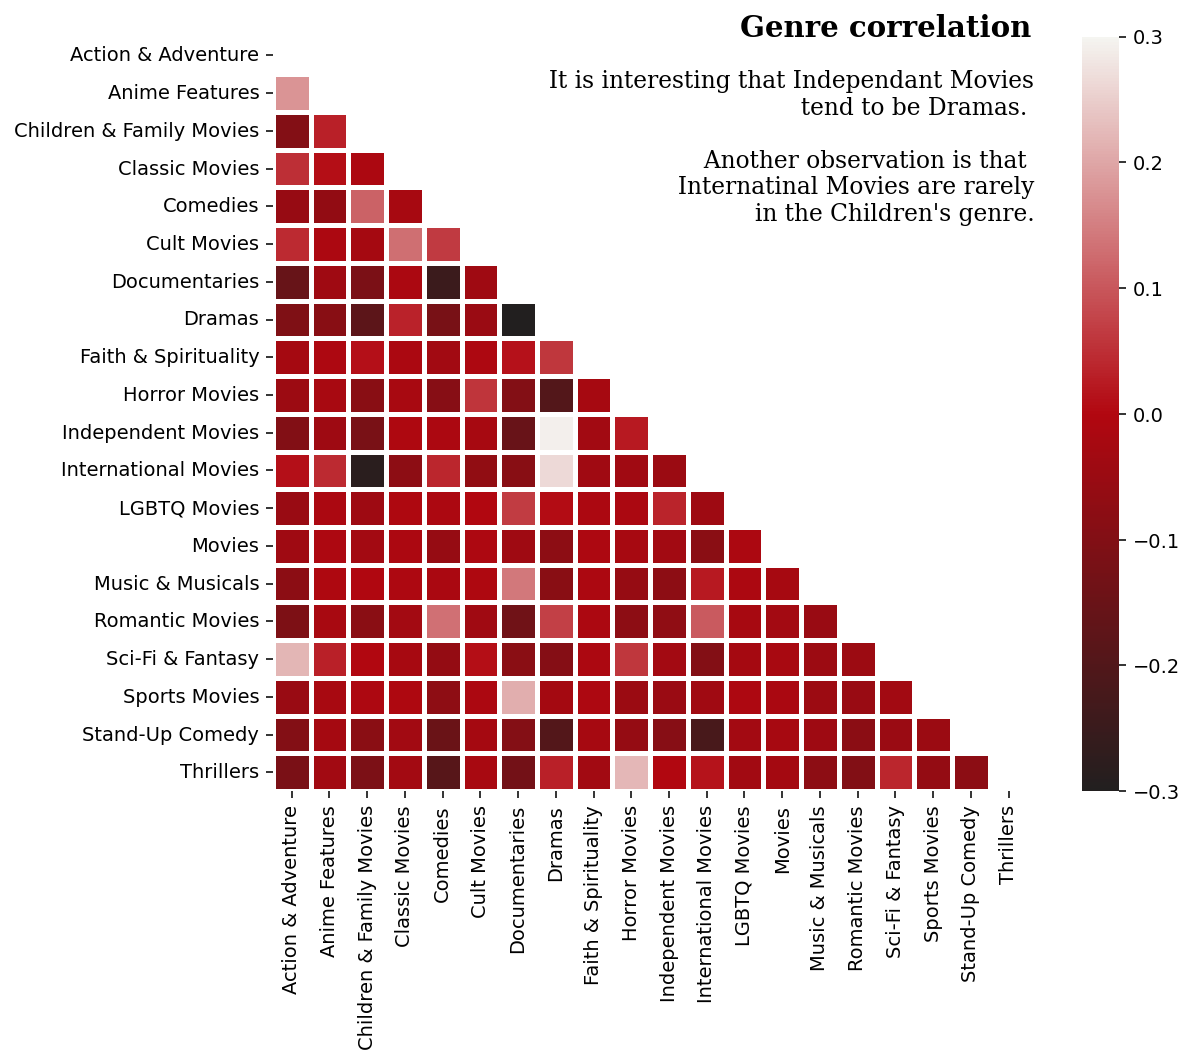

In [66]:
df_tv = df[df['type']=='TV Show']
df_movies = df[df['type']=='Movie']

genre_heatmap(df_movies, 'Movie')
plt.show()

In [73]:
data = df.groupby('first_country')[['first_country','count']].sum().sort_values(by='count',ascending=False).reset_index()[:10]
data = data['first_country']

df_heatmap = df.loc[df['first_country'].isin(data)]

In [74]:
df_heatmap = pd.crosstab(df_heatmap['first_country'],df_heatmap['target_ages'],normalize = "index").T

In [76]:
df_heatmap.columns

Index(['Australia', 'Canada', 'France', 'India', 'Japan', 'Mexico', 'S. Korea',
       'Spain', 'UK', 'United States'],
      dtype='object', name='first_country')

## 타겟 연령층
- 특정 연령층을 대상으로 진행하는지 혹은 나라마다 다른지?

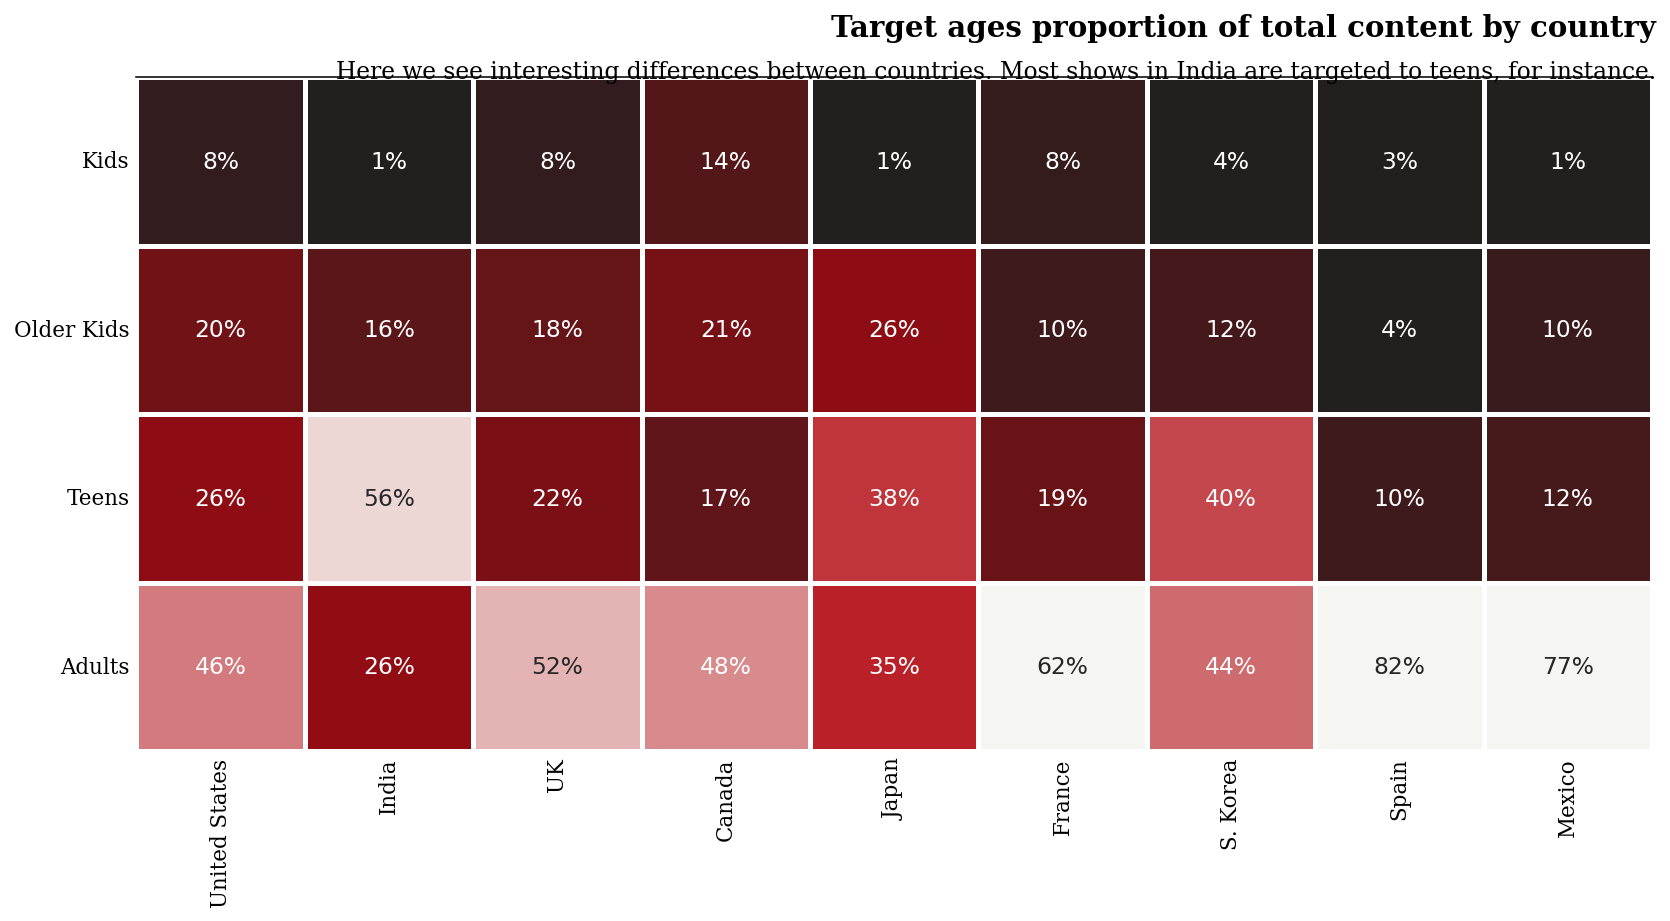

In [79]:
fig, ax = plt.subplots(1, 1, figsize=(12, 12))

country_order2 = ['United States', 'India', 'UK', 'Canada', 'Japan', 'France', 'S. Korea', 'Spain',
       'Mexico']

age_order = ['Kids','Older Kids','Teens','Adults']

sns.heatmap(df_heatmap.loc[age_order,country_order2],cmap=cmap,square=True, linewidth=2.5,cbar=False,
            annot=True,fmt='1.0%',vmax=.6,vmin=0.05,ax=ax,annot_kws={"fontsize":12})

ax.spines['top'].set_visible(True)


fig.text(.99, .725, 'Target ages proportion of total content by country', fontweight='bold', fontfamily='serif', fontsize=15,ha='right')   
fig.text(0.99, 0.7, 'Here we see interesting differences between countries. Most shows in India are targeted to teens, for instance.',ha='right', fontsize=12,fontfamily='serif') 

ax.set_yticklabels(ax.get_yticklabels(), fontfamily='serif', rotation = 0, fontsize=11)
ax.set_xticklabels(ax.get_xticklabels(), fontfamily='serif', rotation=90, fontsize=11)

ax.set_ylabel('')    
ax.set_xlabel('')
ax.tick_params(axis=u'both', which=u'both',length=0)
plt.tight_layout()
plt.show()

- 히트맵 파라미터
    - fmt='1.0%' : 숫자 입력 형태, 1%형태로 입력
    - annot : 각 셀의 값 표기 유무
    - cbar : colorbar 표시할지 말지

매우 흥미로운 결과입니다.

문화적으로 유사한 국가들 간의 유사성을 주목하는 것도 흥미롭다 - 미국과 영국은 넷플릭스의 목표 연령과 밀접하게 일치하지만, 인도나 일본과 크게 다르게 나타난 것을 알 수 있습니다!

## 컨텐츠가 공개되는 시점, 추가되는 시점의 차이를 계산

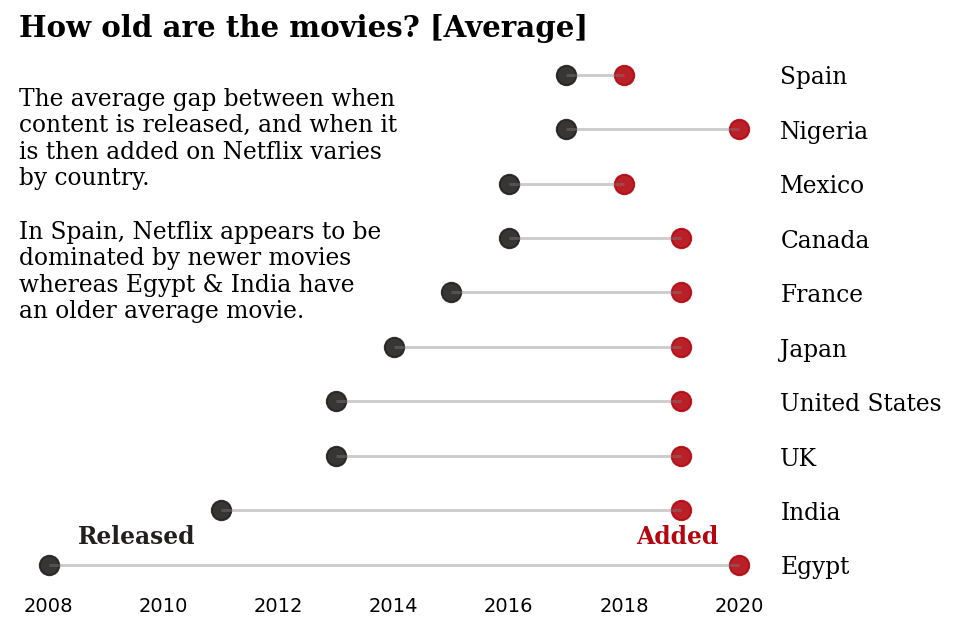

In [92]:
# 그룹화
data = df_movies.groupby('first_country')[['first_country','count']].sum().sort_values(by='count',ascending=False).reset_index()[:10]
data = data['first_country']
df_loli = df_movies.loc[df_movies['first_country'].isin(data)]

loli = df_loli.groupby('first_country')['release_year','year_added'].mean().round()

# 첫번째 값에 따라 순서 변경
ordered_df = loli.sort_values(by='release_year')

ordered_df_rev = loli.sort_values(by='release_year',ascending=False)

my_range = range(1, len(loli.index)+1) # 순서 설정

fig, ax = plt.subplots(1, 1, figsize=(7,5))

fig.text(0.13, 0.9, 'How old are the movies? [Average]', fontsize=15, fontweight='bold', fontfamily='serif')
plt.hlines(y=my_range, xmin=ordered_df['release_year'], xmax=ordered_df['year_added'], color='grey', alpha=0.4)
plt.scatter(ordered_df['release_year'], my_range, color='#221f1f',s=100, alpha=0.9, label='Average release date')
plt.scatter(ordered_df['year_added'], my_range, color='#b20710',s=100, alpha=0.9 , label='Average added date')

for s in ['top', 'left', 'right', 'bottom']:
    ax.spines[s].set_visible(False)
    
# 눈금은 제거, 레이블은 유지
ax.tick_params(axis=u'both', which=u'both',length=0)
# y축을 오른쪽으로 옮김
ax.yaxis.tick_right()

# 축을 국가명으로 변경
plt.yticks(my_range, ordered_df.index)  
plt.yticks(fontname='serif',fontsize=12)

# Custome legend
fig.text(0.19,0.175,"Released", fontweight="bold", fontfamily='serif', fontsize=12, color='#221f1f')
fig.text(0.76,0.175,"Added", fontweight="bold", fontfamily='serif', fontsize=12, color='#b20710')

fig.text(0.13, 0.46, 
'''The average gap between when 
content is released, and when it
is then added on Netflix varies
by country. 

In Spain, Netflix appears to be 
dominated by newer movies 
whereas Egypt & India have
an older average movie.
'''

, fontsize=12, fontweight='light', fontfamily='serif')

plt.show()

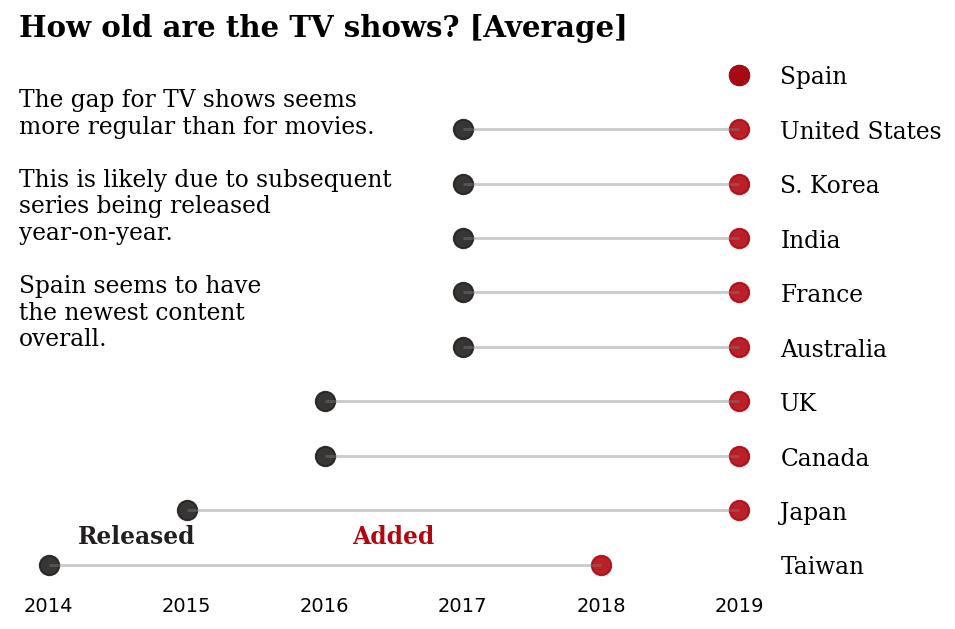

In [93]:
data = df_tv.groupby('first_country')[['first_country','count']].sum().sort_values(by='count',ascending=False).reset_index()[:10]
data = data['first_country']
df_loli = df_tv.loc[df_tv['first_country'].isin(data)]

loli = df_loli.groupby('first_country')['release_year','year_added'].mean().round()

ordered_df = loli.sort_values(by='release_year')

ordered_df_rev = loli.sort_values(by='release_year',ascending=False)

my_range=range(1,len(loli.index)+1)

fig, ax = plt.subplots(1, 1, figsize=(7, 5))

fig.text(0.13, 0.9, 'How old are the TV shows? [Average]', fontsize=15, fontweight='bold', fontfamily='serif')
plt.hlines(y=my_range, xmin=ordered_df['release_year'], xmax=ordered_df['year_added'], color='grey', alpha=0.4)
plt.scatter(ordered_df['release_year'], my_range, color='#221f1f',s=100, alpha=0.9, label='Average release date')
plt.scatter(ordered_df['year_added'], my_range, color='#b20710',s=100, alpha=0.9 , label='Average added date')

for s in ['top', 'left', 'right', 'bottom']:
    ax.spines[s].set_visible(False)
    
ax.yaxis.tick_right()
plt.yticks(my_range, ordered_df.index)
plt.yticks(fontname = "serif",fontsize=12)


fig.text(0.19,0.175,"Released", fontweight="bold", fontfamily='serif', fontsize=12, color='#221f1f')

fig.text(0.47,0.175,"Added", fontweight="bold", fontfamily='serif', fontsize=12, color='#b20710')


fig.text(0.13, 0.42, 
'''The gap for TV shows seems
more regular than for movies.

This is likely due to subsequent
series being released
year-on-year.

Spain seems to have
the newest content
overall.
'''

, fontsize=12, fontweight='light', fontfamily='serif')


ax.tick_params(axis=u'both', which=u'both',length=0)

plt.show()

In [132]:
us_ind = df[(df['first_country'] == 'United States') | (df['first_country'] == 'India' )]

data_sub = df.groupby('first_country')['year_added'].value_counts().unstack().fillna(0).loc[['United States','India']].cumsum(axis=0).T

In [133]:
us_ind

,show_id,type,title,director,cast,country,date_added,release_year,rating,duration,listed_in,description,month_added,month_name_added,year_added,count,first_country,target_ages,genre
0,s1,Movie,Dick Johnson Is Dead,Kirsten Johnson,No Data,United States,2021-09-25,2020,PG-13,90 min,Documentaries,"As her father nears the end of his life, filmm...",9,September,2021,1,United States,Teens,[Documentaries]
2,s3,TV Show,Ganglands,Julien Leclercq,"Sami Bouajila, Tracy Gotoas, Samuel Jouy, Nabi...",United States,2021-09-24,2021,TV-MA,1 Season,"Crime TV Shows, International TV Shows, TV Act...",To protect his family from a powerful drug lor...,9,September,2021,1,United States,Adults,"[Crime TV Shows, International TV Shows, TV Ac..."
3,s4,TV Show,Jailbirds New Orleans,No Data,No Data,United States,2021-09-24,2021,TV-MA,1 Season,"Docuseries, Reality TV","Feuds, flirtations and toilet talk go down amo...",9,September,2021,1,United States,Adults,"[Docuseries, Reality TV]"
4,s5,TV Show,Kota Factory,No Data,"Mayur More, Jitendra Kumar, Ranjan Raj, Alam K...",India,2021-09-24,2021,TV-MA,2 Seasons,"International TV Shows, Romantic TV Shows, TV ...",In a city of coaching centers known to train I...,9,September,2021,1,India,Adults,"[International TV Shows, Romantic TV Shows, TV..."
5,s6,TV Show,Midnight Mass,Mike Flanagan,"Kate Siegel, Zach Gilford, Hamish Linklater, H...",United States,2021-09-24,2021,TV-MA,1 Season,"TV Dramas, TV Horror, TV Mysteries",The arrival of a charismatic young priest brin...,9,September,2021,1,United States,Adults,"[TV Dramas, TV Horror, TV Mysteries]"
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8802,s8803,Movie,Zodiac,David Fincher,"Mark Ruffalo, Jake Gyllenhaal, Robert Downey J...",United States,2019-11-20,2007,R,158 min,"Cult Movies, Dramas, Thrillers","A political cartoonist, a crime reporter and a...",11,November,2019,1,United States,Adults,"[Cult Movies, Dramas, Thrillers]"
8803,s8804,TV Show,Zombie Dumb,No Data,No Data,United States,2019-07-01,2018,TV-Y7,2 Seasons,"Kids' TV, Korean TV Shows, TV Comedies","While living alone in a spooky town, a young g...",7,July,2019,1,United States,Older Kids,"[Kids' TV, Korean TV Shows, TV Comedies]"
8804,s8805,Movie,Zombieland,Ruben Fleischer,"Jesse Eisenberg, Woody Harrelson, Emma Stone, ...",United States,2019-11-01,2009,R,88 min,"Comedies, Horror Movies",Looking to survive in a world taken over by zo...,11,November,2019,1,United States,Adults,"[Comedies, Horror Movies]"
8805,s8806,Movie,Zoom,Peter Hewitt,"Tim Allen, Courteney Cox, Chevy Chase, Kate Ma...",United States,2020-01-11,2006,PG,88 min,"Children & Family Movies, Comedies","Dragged from civilian life, a former superhero...",1,January,2020,1,United States,Older Kids,"[Children & Family Movies, Comedies]"


In [134]:
us_ind['first_country'].value_counts().index

Index(['United States', 'India'], dtype='object')

## USA & India
- 두 거대 국가 비교

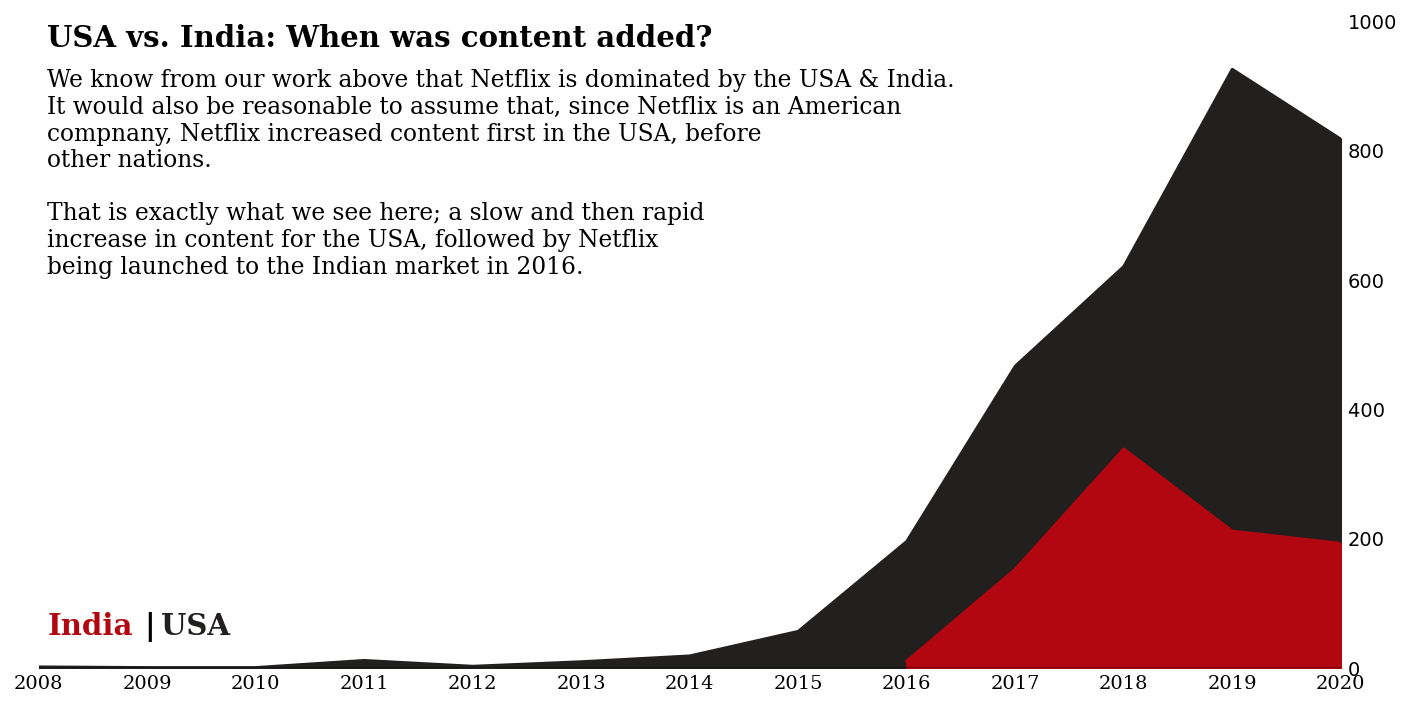

In [135]:
fig, ax = plt.subplots(1, 1, figsize=(12,6))
color = ['#221f1f', '#b20710','#f5f5f1']

for i, hs in enumerate(us_ind['first_country'].value_counts().index):
    hs_built = us_ind[us_ind['first_country']==hs]['year_added'].value_counts().sort_index()
    ax.plot(hs_built.index, hs_built, color=color[i], label=hs)
    # 밑에 색깔로 채우기
    ax.fill_between(hs_built.index, 0, hs_built, color=color[i], label=hs)
    
ax.set_ylim(0,1000)
for s in ['top','right']:
    ax.spines[s].set_visible(False)
    
# y축을 오른쪽으로 이동
ax.yaxis.tick_right()

ax.axhline(y=0, color='black', linewidth=1.3, alpha=.4)

for s in ['top', 'right','bottom','left']:
    ax.spines[s].set_visible(False)
    
ax.grid(False)
ax.set_xticklabels(data_sub. index, fontfamily='serif', rotation=0)
ax.margins(x=0)

ax.set_xlim(2008,2020)
plt.xticks(np.arange(2008, 2021, 1))

fig.text(0.13, 0.85, 'USA vs. India: When was content added?', fontsize=15, fontweight='bold', fontfamily='serif')
fig.text(0.13, 0.58, 
'''
We know from our work above that Netflix is dominated by the USA & India.
It would also be reasonable to assume that, since Netflix is an American
compnany, Netflix increased content first in the USA, before 
other nations. 

That is exactly what we see here; a slow and then rapid
increase in content for the USA, followed by Netflix 
being launched to the Indian market in 2016.'''

, fontsize=12, fontweight='light', fontfamily='serif')



fig.text(0.13,0.15,"India", fontweight="bold", fontfamily='serif', fontsize=15, color='#b20710')
fig.text(0.188,0.15,"|", fontweight="bold", fontfamily='serif', fontsize=15, color='black')
fig.text(0.198,0.15,"USA", fontweight="bold", fontfamily='serif', fontsize=15, color='#221f1f')


ax.tick_params(axis=u'both', which=u'both',length=0)


plt.show()

- 미국이 지배적인 것을 알 수 있다.

In [141]:
us_ind = df[(df['first_country'] == 'United States') | (df['first_country'] == 'India' )]

data_sub = df.groupby('first_country')['year_added'].value_counts().unstack().fillna(0).loc[['United States','India']].cumsum(axis=0).T
data_sub.insert(0, "base", np.zeros(len(data_sub)))

data_sub = data_sub.add(-us_ind['year_added'].value_counts()/2, axis=0)

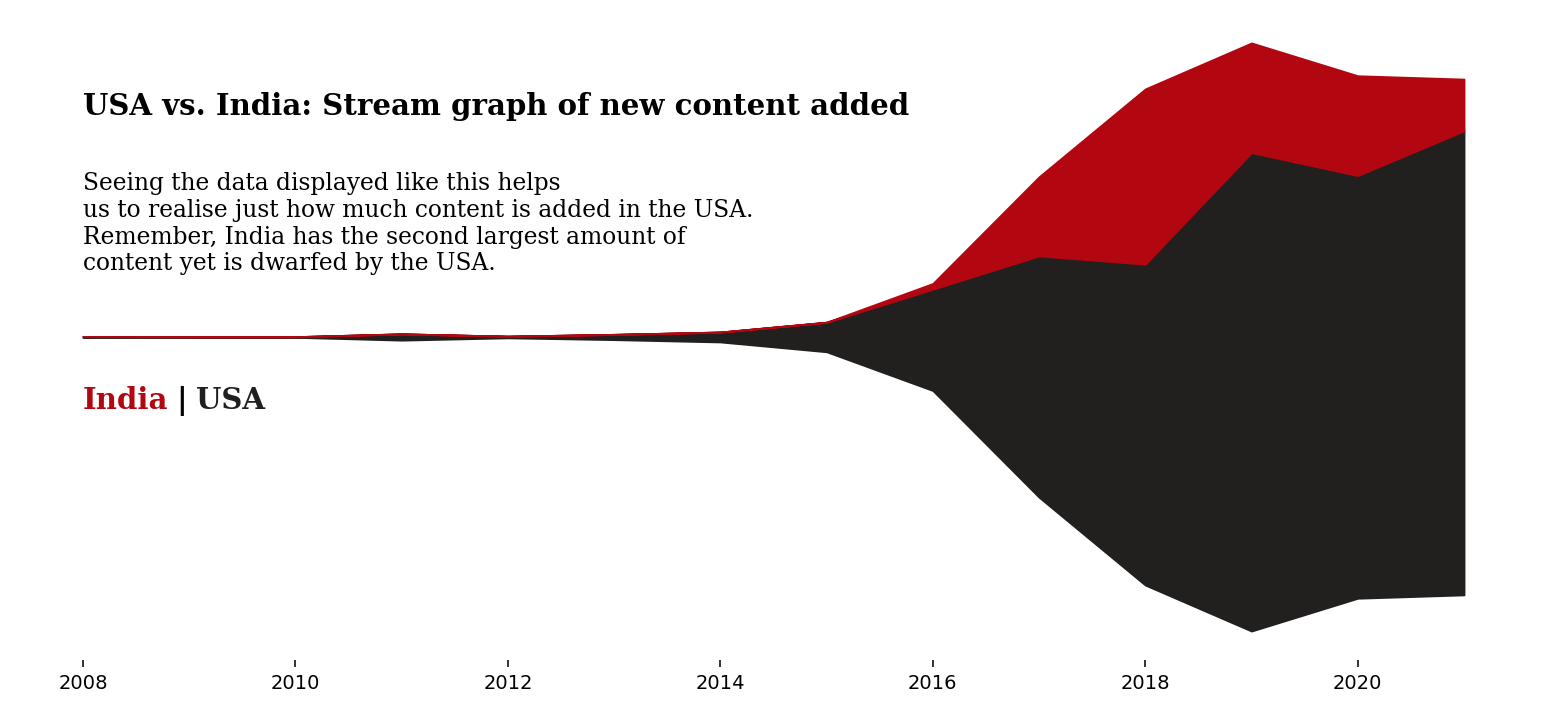

In [142]:
fig, ax = plt.subplots(1, 1, figsize=(14, 6))
color = ['#b20710','#221f1f'][::-1]
hs_list = data_sub.columns
hs_built = data_sub[hs]

for i, hs in enumerate(hs_list):
    if i == 0 : continue
    ax.fill_between(hs_built.index, data_sub.iloc[:,i-1], data_sub.iloc[:,i], color=color[i-1])
    
for s in ['top', 'right', 'bottom', 'left']:
    ax.spines[s].set_visible(False)
ax.set_axisbelow(True)
ax.set_yticks([])
#ax.legend(loc='upper left')
ax.grid(False)

fig.text(0.16, 0.76, 'USA vs. India: Stream graph of new content added', fontsize=15, fontweight='bold', fontfamily='serif')
fig.text(0.16, 0.575, 
'''
Seeing the data displayed like this helps 
us to realise just how much content is added in the USA.
Remember, India has the second largest amount of
content yet is dwarfed by the USA.'''

, fontsize=12, fontweight='light', fontfamily='serif')

fig.text(0.16,0.41,"India", fontweight="bold", fontfamily='serif', fontsize=15, color='#b20710')
fig.text(0.208,0.41,"|", fontweight="bold", fontfamily='serif', fontsize=15, color='black')
fig.text(0.218,0.41,"USA", fontweight="bold", fontfamily='serif', fontsize=15, color='#221f1f')


ax.tick_params(axis=u'y', which=u'both',length=0)

plt.show()

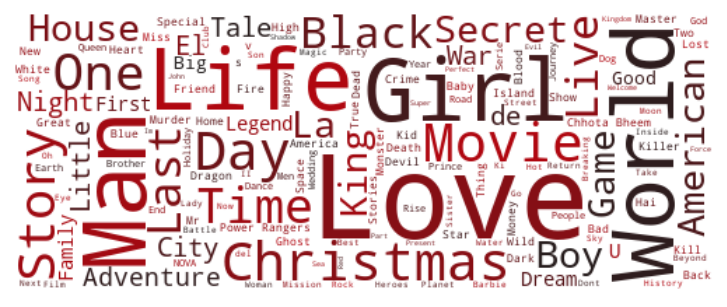

In [144]:
from wordcloud import WordCloud
import random
from PIL import Image
import matplotlib

cmap = matplotlib.colors.LinearSegmentedColormap.from_list("", ['#221f1f', '#b20710'])

text = str(list(df['title'])).replace(',','').replace('[','').replace("'", '').replace(']', '').replace('.', '')

wordcloud = WordCloud(background_color = 'white', width = 500,  height = 200,colormap=cmap, max_words = 150).generate(text)
plt.figure(figsize=(5,5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.tight_layout(pad=0)
plt.show()

- tight_layout() : 자동으로 명시된 여백에 관련된 서브플롯 파라미터 조정
    - pad : figure의 모서리와 서브플롯의 모서리 사이 여백 설정
    - hpad , wpad : 서브플롯의 모서리 간 높이 및 너비 여백 설정 h는 높이, w은 너비